In [64]:
from matplotlib import pyplot as plt
import platform, os, sys, pprint, h5py
from tqdm import tqdm, trange
import numpy as np
from glob import glob
from tabulate import tabulate
from pprint import pprint
from importlib import reload
from mpl_toolkits.axes_grid.inset_locator import inset_axes

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\Gerwin\Documents\Code')
    sys.path.append(r'C:\_Lib\python')
    from BEMHelper import interpolate_slow
    from slab.circuitqed import SingleElectron
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import artificial_anneal as anneal
from glob import glob 
from pprint import pprint
from mpltools import color

%matplotlib inline
# %config InlineBackend.figure_format='retina'

## Load electrostatic potential from simulation data 

In [65]:
from TrapAnalysis.solve_eom import FullSolver

settings_file = r"S:\Gerwin\Electron on helium\Maxwell\M018 Yggdrasil\M018V6"
settings_file += r"\With L3 etch - just trap\settings.json"
fs = FullSolver(settings_file)

# x = 0.15

# mu_guess = -0.265
# def f_mu(mu):
#     return -1.755 - 7*mu

mu_guess = -0.27
x_sep = 0.30
def f_mu(mu):
    return -1.755 - 7 * mu

def Vrg_diag(Vtrap_diag, mu_guess, x_sep):
    return -1/2.45 * (Vtrap_diag - f_mu(mu_guess)) - x_sep

Vtrap = np.linspace(0.225, 0.350, 101)  #np.array([0.26])
Vrg = np.linspace(Vrg_diag(Vtrap[0], mu_guess, x_sep), 
                  Vrg_diag(Vtrap[1], mu_guess, x_sep), len(Vtrap)) #[Vrg_diag(Vtrap[0], mu_guess, x_sep)] 
Vres = 0.60 * np.ones(len(Vtrap)) 
Vtg = 0.00 * np.ones(len(Vtrap))
Vcg = None

In [66]:
fs.set_rf_interpolator()
fs.set_dc_interpolator(Vres[0], Vtrap[0], Vrg[0], Vtg[0])

In [67]:
from scipy.constants import hbar, m_e, elementary_charge as q_e

Npts = 501
omega0 = 2 * np.pi * 6.3971E9
Z0 = 100
prefactor = q_e * np.sqrt(hbar * omega0**2 * Z0 / 2) * 1 / (2 * np.pi * hbar)
x = np.linspace(-1.5E-6, 1.5E-6, Npts)
y = np.linspace(-3E-6, 3E-6, Npts)
X, Y = np.meshgrid(x, y)
N_evals = 15

ground_state_couplings = list()
excited_state_couplings = list()
electron_frequencies = list()

for vres, vtrap, vrg, vtg in tqdm(zip(Vres, Vtrap, Vrg, Vtg)):
    fs.update_dc_interpolator(vres, vtrap, vrg, vtg)
    U = fs.dc_interpolator.ev(X, Y)
    min_idx = np.unravel_index(np.argmin(U), np.shape(U))

    if 0: 
        fig = plt.figure(figsize=(5, 4.))
        common.configure_axes(13)
        plt.pcolormesh(X * 1E6, Y * 1E6, U, cmap=plt.cm.Spectral, vmin=np.min(U), vmax=0.0)
        plt.plot(X[min_idx] * 1E6, Y[min_idx] * 1E6, 'o', color='violet', label="Minimum")
        plt.legend(loc=0, frameon=False, prop={"size" : 10})
        plt.colorbar()
        plt.ylabel("$y$ ($\mu$m)")
        plt.xlabel("$x$ ($\mu$m)")
    
    el = SingleElectron(x, y, potential_function=fs.dc_interpolator.ev, solve=False)
    el.sparsify(num_levels=N_evals)
    Evals, Evecs = el.solve(sparse_args=el.sparse_args)

    Psis = el.get_2Dpsis(N_evals)
    mode_frequencies = (Evals - Evals[0]) * hbar**2 / (2 * q_e * m_e) * q_e / (2 * np.pi * hbar)
    
#     fig = plt.figure(figsize=(10., 12.))

#     for i in range(N_evals):
#         max_idx = np.unravel_index(np.argmax(Psis[i]), np.shape(U))
#         cmax = np.max(np.abs(Psis[i]))
#         cmin = -cmax

#         plt.subplot(5, 3, i+1)
#         plt.pcolormesh(el.x * 1E6, el.y * 1E6, Psis[i], cmap=plt.cm.RdYlBu_r, vmin=cmin, vmax=cmax)
#         if 0:
#             plt.plot(X[min_idx] * 1E6, Y[min_idx] * 1E6, 'o', color='black', label="Classical minimum")
#             plt.legend(loc=0, prop={"size" : 10}, frameon=False)

#         plt.title("Mode #%d | %.3f GHz" % (i, (mode_frequencies[i] - mode_frequencies[0])/1E9))
#         plt.hlines(0.0, -0.75, -0.25, linestyles='--', color='k', alpha=0.5)
#         plt.xlabel("$x$ ($\mu$m)")
#         plt.ylabel("$y$ ($\mu$m)")
#         plt.xlim(-0.75, -0.25)
#         plt.ylim(-0.5, 0.5)

#     fig.tight_layout()
#     common.save_figure(fig, save_path=r"S:\Gerwin\Electron on helium\Single Electron Schrodinger Solver")
    
    gi0 = np.zeros(N_evals)
    gi1 = np.zeros(N_evals)
    
    for i in range(N_evals):
        gi0[i] = prefactor * np.sum(Psis[i] * ( X * fs.Ex(X, Y) + Y * fs.Ey(X, Y) ) * np.conjugate(Psis[0]))
        gi1[i] = prefactor * np.sum(Psis[i] * ( X * fs.Ex(X, Y) + Y * fs.Ey(X, Y) ) * np.conjugate(Psis[1]))
    
    excited_state_couplings.append(gi1)
    ground_state_couplings.append(gi0)
    electron_frequencies.append(mode_frequencies)

ground_state_couplings = np.array(ground_state_couplings)
electron_frequencies = np.array(electron_frequencies)
excited_state_couplings = np.array(excited_state_couplings)

101it [51:06, 29.38s/it]


## Eigenfrequencies as function of $V_\mathrm{trap}$

C:\Users\Gerwin\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


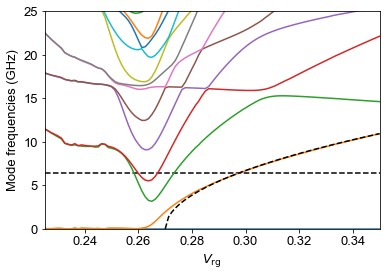

In [68]:
sweepV = Vtrap
sweep_label = r"$V_\mathrm{rg}$"
startV = 0.270

plt.figure()
common.configure_axes(13)
plt.plot(sweepV, electron_frequencies/1E9)
plt.ylim(0, 25)
plt.xlim(np.min(sweepV), np.max(sweepV))
plt.xlabel(sweep_label)
plt.ylabel("Mode frequencies (GHz)")

def sqrt_fun(x, *p):
    return p[0] * np.sqrt(x - startV)

fr, ferr = kfit.fitbetter(Vtrap, electron_frequencies[:, 1]/1E9, sqrt_fun, fitparams=[39], domain=(startV, 0.400))

selection = Vtrap > startV
plt.plot(Vtrap, sqrt_fun(Vtrap, *fr), '--k')
plt.hlines(omega0/(2*np.pi*1e9), sweepV[0], sweepV[-1], linestyles='--')
# plt.plot(Vtrap, 39 * np.sqrt((Vtrap - 0.265)), '--k')

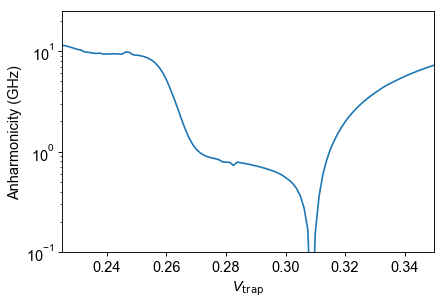

In [69]:
f_ge = (electron_frequencies[:, 1] - electron_frequencies[:, 0])/1E9
f_ef = (electron_frequencies[:, 2] - electron_frequencies[:, 1])/1E9

plt.figure()
common.configure_axes(13)
plt.plot(Vtrap, np.abs(f_ef - f_ge))
plt.yscale('log')
plt.ylim(0.1, 25)
plt.xlim(np.min(Vtrap), np.max(Vtrap))
plt.xlabel("$V_\mathrm{trap}$")
plt.ylabel("Anharmonicity (GHz)")

In [70]:
fr

array([ 38.67022664])

for $x = 0.15$, the $g-e$ transition is given by $f = 38.85 \sqrt{V_\mathrm{trap} - 0.267}$

In [71]:
resonant_idx = common.find_nearest(electron_frequencies[:, 1], 6.5E9)
print(Vtrap[resonant_idx])
print((electron_frequencies[resonant_idx+1, 1]-electron_frequencies[resonant_idx-1, 1])/(2*np.diff(Vtrap)[0]) * 1E-6 * 1E-3, "MHz/mV")

0.29875
111.559917926 MHz/mV


## Couplings as function of $V_\mathrm{trap}$

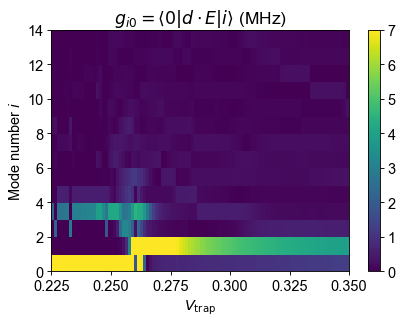

In [77]:


plt.pcolormesh(Vtrap, np.arange(0, N_evals), 1E-6 * np.abs(ground_state_couplings[:, :].T))
plt.colorbar()
plt.clim(0, 7)
plt.xlabel("$V_\mathrm{trap}$")
plt.ylabel("Mode number $i$")
plt.title(r"$g_{i0} = \langle 0 | d \cdot E | i \rangle$ (MHz)")

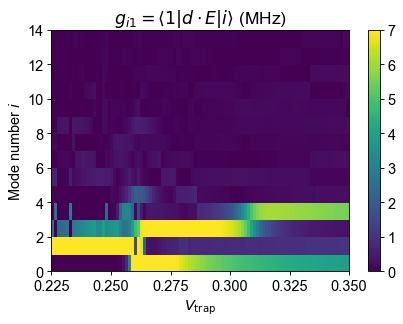

In [76]:
plt.pcolormesh(Vtrap, np.arange(0, N_evals), 1E-6 * np.abs(excited_state_couplings[:, :].T))
plt.colorbar()
plt.clim(0, 7)
plt.xlabel("$V_\mathrm{trap}$")
plt.ylabel("Mode number $i$")
plt.title(r"$g_{i1} = \langle 1 | d \cdot E | i \rangle$ (MHz)")

## Expected cavity frequency shift as function of $V_\mathrm{trap}$

The theory comes from the following <a href="http://iopscience.iop.org/article/10.1088/1361-648X/aa7b4d/pdf">paper</a>:
<i>Cavity QED with hybrid nanocircuits: from atomiclike physics to condensed matter phenomena</i>, Audrey Cottet <i>et al.</i> 2017 J. Phys.: Condens. Matter <b>29</b> 433002

The basic idea is to sum over all mode contributions to get the susceptibility: 
$$\Xi(\omega_{RF}) = \sum_{i,j} \frac{g_{ij}^2 (n_j-n_i)}{\omega_{RF} - \omega_{ij} + i \Gamma_{ij}}$$
and plug this into the expression for the outgoing cavity field
$$\frac{b_t}{b_{in}} = \frac{2 \sqrt{\kappa_c/2\cdot \kappa_c/2}}{\omega_{RF}-\omega_0 + i \kappa_{tot} - \Xi(\omega_{RF})}$$
The only trick then is to plot $(b_t/b_{in})^*$ which is what you measure experimentally.

In [47]:
def chi(omega_drive, omega_ij, g_ij, n_i, n_j, gamma_ij):
    # For most of the population in the ground state: n_i = 0
#     n_i = 0
    return g_ij**2 * (n_j - n_i) / (omega_drive - omega_ij + 1j * gamma_ij)

In [48]:
def signal(omega_0, omega_drive, kappa_i, kappa_c, susceptibility):
    return 2 * np.sqrt(kappa_c/2. * kappa_c/2.) / (omega_drive - omega_0 + 1j * (kappa_i + kappa_c) - susceptibility)

Let's plot the individual modes and their coupling to the cavity

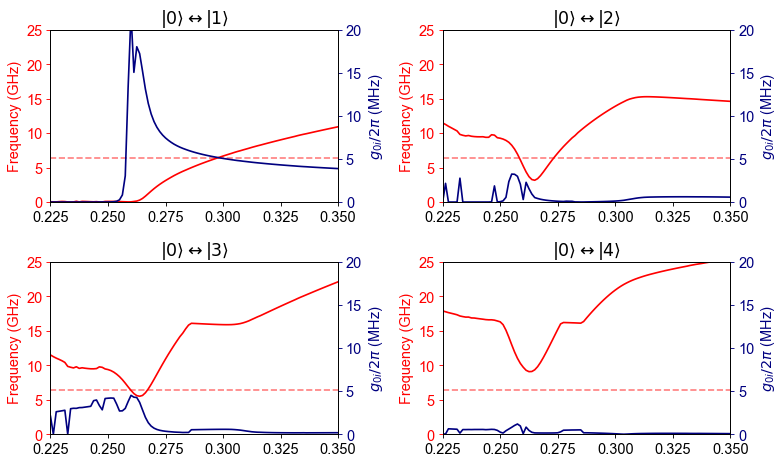

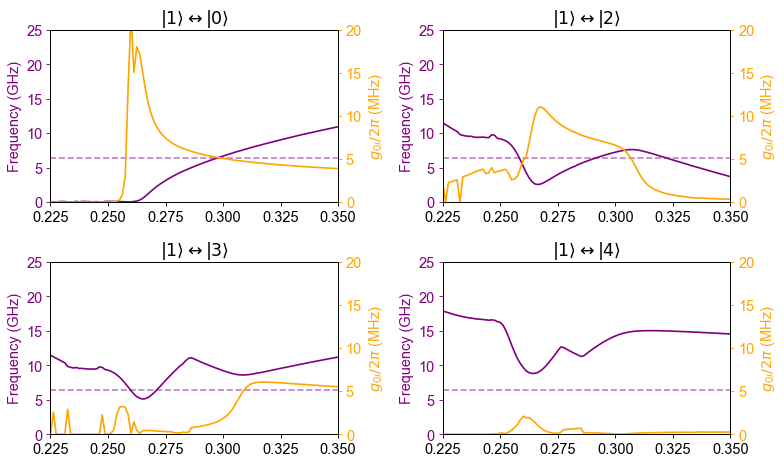

In [93]:
omega_0 = omega0
omega_drive = omega_0
kappa_i = omega_0 / 40E3
kappa_c = omega_0 / 20E3

# susceptibility = np.zeros(len(Vtrap), dtype=np.complex128)

fig = plt.figure(figsize=(10.,6.))

for k, modeidx in enumerate(np.arange(1, 5)):
#     omega_ij = 2 * np.pi * electron_frequencies[:, k]
#     g_ij = 2 * np.pi * ground_state_couplings[:, k]
#     gamma_ij = 2* np.pi * 100E6
#     n_i = 0.0 # to level population
#     n_j = 1.0 # from level population
#     susceptibility += chi(omega_drive, omega_ij, g_ij, n_i, n_j, gamma_ij)
    
    plt.subplot(2, 2, k+1)
    ax1, ax2 = common.setup_twinax(color1='red', color2='navy')
    ax1.plot(Vtrap, electron_frequencies[:, modeidx] / 1E9, color='red')
    ax1.hlines(omega_0/(2*np.pi*1E9), np.min(Vtrap), np.max(Vtrap), linestyles='--', color='r', alpha=0.5)
    ax1.set_ylabel("Frequency (GHz)")
    ax2.plot(Vtrap, np.abs(ground_state_couplings[:, modeidx]) / 1E6, color='navy')
    ax2.set_ylabel("$g_{0i}/2\pi$ (MHz)")
    ax1.set_xlim(np.min(Vtrap), np.max(Vtrap))
    ax2.set_xlim(np.min(Vtrap), np.max(Vtrap))
    
    ax2.set_ylim(0, 20)
    ax1.set_ylim(0, 25)
    plt.title(r"$|0\rangle \leftrightarrow | %d \rangle$" % modeidx)
    
fig.tight_layout()

fig = plt.figure(figsize=(10.,6.))

for k, modeidx in enumerate(np.delete(np.arange(0, 5), 1)):
    plt.subplot(2, 2, k+1)
    ax1, ax2 = common.setup_twinax(color1='purple', color2='orange')
    ax1.plot(Vtrap, np.abs(electron_frequencies[:, 1] - electron_frequencies[:, modeidx]) / 1E9, color='purple')
    ax1.hlines(omega_0/(2*np.pi*1E9), np.min(Vtrap), np.max(Vtrap), linestyles='--', color='purple', alpha=0.5)
    ax1.set_ylabel("Frequency (GHz)")
    ax2.plot(Vtrap, np.abs(excited_state_couplings[:, modeidx]) / 1E6, color='orange')
    ax2.set_ylabel("$g_{0i}/2\pi$ (MHz)")
    ax1.set_xlim(np.min(Vtrap), np.max(Vtrap))
    ax2.set_xlim(np.min(Vtrap), np.max(Vtrap))
    
    ax2.set_ylim(0, 20)
    ax1.set_ylim(0, 25)
    plt.title(r"$|1\rangle \leftrightarrow | %d \rangle$" % modeidx)
    
fig.tight_layout()

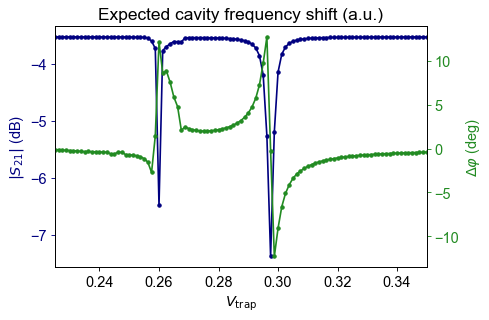

In [63]:
fig = plt.figure()
common.configure_axes(13)
ax1, ax2 = common.setup_twinax(color1='navy', color2='forestgreen')
plt.title("Expected cavity frequency shift (a.u.)")

for gs_pop in [1.0]:
    susceptibility = np.zeros(len(Vtrap), dtype=np.complex128)
    
    for k in np.arange(1, 5):
        omega_ij = 2 * np.pi * electron_frequencies[:, k]
        g_ij = 2 * np.pi * ground_state_couplings[:, k]
        gamma_ij = 2* np.pi * 100E6
        susceptibility += chi(omega_drive, omega_ij, g_ij, gs_pop, gamma_ij)

    s = np.conjugate(signal(omega_0, omega_drive, kappa_i, kappa_c, susceptibility))

    
    ax2.plot(Vtrap, -90 + 180 / np.pi * np.arctan2(np.imag(s), np.real(s)), '.-', color='forestgreen')
    ax1.plot(Vtrap, 20 * np.log10(np.abs(s)), '.-', color='navy')
    ax1.set_xlim(np.min(Vtrap), np.max(Vtrap))
    ax1.set_xlabel("$V_\mathrm{trap}$")
    ax1.set_ylabel(r"$|S_{21}|$ (dB)")
    ax2.set_ylabel(r"$\Delta \varphi$ (deg)")